# Evaluating the impact of the Contact Tracing App Immuni in Milan to contrast COVID-19 contagion: an Agent-Based Model approach with GIS structure
## Python script
### Group Memebers:
### Burresi Filippo - 3023033
### Di Bonaventura Chiara - 3031750
### Fabbri Caterina - 3029912
### Pisano Alessandro - 3017698

In [1]:
#Importing package for the analysis
#This code is partially insipred by https://github.com/Corvince/mesa-geo/

from mesa import Model
from mesa.datacollection import DataCollector
from mesa.time import BaseScheduler
from mesa_geo.geoagent import GeoAgent, AgentCreator
from mesa_geo import GeoSpace
from shapely.geometry import Point

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

nel = pd.read_csv('Milan Density.csv', encoding = 'ISO8859-1')
data = pd.read_excel("dati_covid_milano_MARZO.xlsx")
data["data"] = pd.to_datetime(data["data"])
data["cum_cases"] = data["n_cases"].cumsum()
data['cum_cases1'] = data['cum_cases']/100 #To adapt to the scale

In [2]:
#Defining funciton to track individuals 

def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Susceptible' and a.immuni == False])

def compute_E(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Exposed' and a.immuni == False])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Infected' and a.immuni == False])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Recovered' and a.immuni == False])

def compute_S_traced(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Susceptible' and a.immuni == True])

def compute_E_traced(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Exposed' and a.immuni == True])

def compute_I_traced(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Infected' and a.immuni == True])

def compute_R_traced(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Recovered' and a.immuni == True])

def compute_Q_exposed_traced(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Exposed' and a.removed == True])

def compute_S_total(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Susceptible'])

def compute_E_total(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Exposed'])

def compute_I_total(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Infected'])

def compute_R_total(model):
    return  sum([1 for a in model.schedule.agents if a.health == 'Recovered'])

def compute_T_aux(model):
    return  sum([1 for a in model.schedule.agents if a.auxiliar == True])

In [3]:
class PersonAgent(GeoAgent):
    """Model class to define an Agent"""
    def __init__(self, 
                 unique_id, 
                 model, 
                 shape, 
                 init_exposed = 0.05, 
                 health = 'Susceptible', 
                 mobility_range = 100,
                 removed = False,
                 exp_len = 0,
                 quar = 0,
                 contact = {},
                 message = False,
                 contagious = False,
                 recovery_time = 0,
                 immuni = False,
                 asympt = False,
                 steps = 0,
                 immuni_on = False,
                 auxiliar = False
                 ):
        """Create a new person agent.(
        :param unique_id:   Unique identifier for the agent
        :param model:       Model in which the agent runs
        :param shape:       Shape object for the agent
        :param init_exposed = 0.5: 
        :param health = 'Susceptible':  Indicator if agent is infected ("Infected", "Susceptible", "Recovered" or "Exposed")
        :param mobility_range = 100:  Range of distance to move in one step (max value)
        :removed = False: If the agent is in the grid or not
        :exp_len = 0: Counter, how much time before the agent start becoming contagious
        :quar = 0: Counter, how long the agent has been exposed
        :contact = {}: dictionary to trace the contact at given time step
        :message = False: if they receive the allert from immuni, set to False
        :contagious = False: if they are contagious, set to False
        :recovery_time = 0: Counter, how long the agent has been exposed
        :immuni = False: If they have the immuni app, set to False
        :asympt = False: If they are asymptomatic, set to False
        :steps = 0: Counter for time steps
        :immuni_on = False: Auxiliar variable to allow the Agent to send the allert with the app only one time, set to False
        :auxiliar = False: Auxiliar variable to track the number of infected agents
        )
        """
        super().__init__(unique_id, model, shape)
        self.health = health
        self.mobility_range = mobility_range
        self.removed = removed
        self.exp_len = exp_len
        self.quar = quar
        self.contact = contact
        self.message = message
        self.contagious = contagious
        self.recovery_time = recovery_time
        self.time_to_develop_symptomps = np.random.gamma(1.87, 1/0.28)  #exposed_symp = 6.6 on average each aagent pick a random value
        self.time_to_become_contagious = random.normalvariate(self.model.date_contagious, self.model.date_contagious/4) #each agent pick a random vlaue. numebr of day to become contagious
        self.immuni = immuni
        self.asympt = asympt
        self.steps = steps
        self.immuni_on = immuni_on 
        self.auxiliar = auxiliar 

        if random.random() < init_exposed: #initalizing the exposed
            self.health = 'Exposed'

        if random.random() < self.model.percentage_imm: #Initalizing people with the Immuni app
            self.immuni = True
            self.immuni_on = True #It will turn off in case the agent will be infected         

    def move(self, dx, dy): 
        """
        Function to move the agent in the map
        :param dx:  Distance to move in x-axis
        :param dy:  Distance to move in y-axis
        """
        return Point(self.shape.x + dx, self.shape.y + dy)    

    def track_contacts(self): 
        """Function to track contacts"""
        neighbors_nodes = self.model.grid.get_neighbors_within_distance(self, self.model.exposure_distance) #Saving contacts within a distance
        neighbors = [a for a in neighbors_nodes if isinstance(a, PersonAgent)] #Saving the neighbors 
        self.contact[self.steps] = neighbors #Track the contact

    def try_to_infect_neighbors(self): 
        """Function to infect neighbors"""
        neighbors_nodes = self.model.grid.get_neighbors_within_distance(self, self.model.exposure_distance) #Saving contacts within a distance
        susceptible_neighbors = [a for a in neighbors_nodes if a.health == 'Susceptible'] #Saving the susceptible neighbours
        
        for a in susceptible_neighbors: 
            if self.random.random() < self.model.beta: #Getting infected with probability beta
                a.health = 'Exposed'                
                if random.random() < self.model.percentage_asympt: #Becoming Aymptomatic with probability percentage_asympt
                    self.asympt = True      
            
    def try_to_develop_symptoms(self): 
        """Function to try to develop symptoms and hence becoming infected"""
        if self.exp_len > self.time_to_develop_symptomps: 
            self.health = 'Infected'
                
    def try_to_become_contagious(self): 
        """Function to try to become contagious"""
        self.exp_len += 1
        if self.exp_len > self.time_to_become_contagious:
            self.contagious = True    
                
    def send_message(self): 
        """Function that send a message the contacts an exposed had 14 day before"""
        for i in range(max(0, len(self.contact)-14), len(self.contact)):
            for j in self.contact[i]:
                j.message = True
        
    def try_to_recovery(self): 
        """Function to try to recovery"""
        if random.random() < (self.model.gamma):
            self.health ='Recovered'      
                    
    def step(self):
        """Advance one step"""
        if self.health == 'Susceptible':
            if self.immuni == True and self.message == True and self.removed == False: #If the person receve the message from the app
                    self.model.grid.remove_agent(self)
                    self.removed = True
                    self.message = False
                    
            elif self.removed == True: #Be removed for 14 days
                self.quar +=1
                if self.quar > 14: 
                    self.model.grid.add_agents(self)
                    self.removed = False
                    self.quar = 0
                    
            else: #If the agent is not removed It moves
                move_x = self.random.randint(-self.mobility_range, self.mobility_range)
                move_y = self.random.randint(-self.mobility_range, self.mobility_range)
                self.shape = self.move(move_x, move_y) 
                if self.immuni == True: 
                    self.track_contacts() 
                
        if self.health == 'Exposed':
            self.try_to_become_contagious()
            
            if self.asympt == False:
                self.try_to_develop_symptoms() 
            else:
                self.try_to_recovery() 
                
            if self.immuni == True and self.message == True and self.removed == False:
                    self.model.grid.remove_agent(self)
                    self.removed = True
                    self.message = False
                    
            if self.removed == False: #If the agent is not removed It moves
                move_x = self.random.randint(-self.mobility_range, self.mobility_range)
                move_y = self.random.randint(-self.mobility_range, self.mobility_range)
                self.shape = self.move(move_x, move_y)
                if self.immuni == True:
                    self.track_contacts()
                    
                if self.contagious == True:
                    self.try_to_infect_neighbors()   
                       
        if self.health == 'Infected':
            self.recovery_time += 1
            
            if self.auxiliar == False:
                self.auxiliar = True
            
            if self.immuni == True and self.immuni_on == True and self.recovery_time > self.model.days_after_swab: #Average time of getting a swab
                self.send_message()
                self.immuni_on = False
                
            self.try_to_recovery()
            
            if self.removed == False:
                self.model.grid.remove_agent(self)
                self.removed = True            
            
        if self.health == 'Recovered':
            if self.removed == True:
                self.model.grid.add_agents(self)
                self.removed = False  
            else:
                move_x = self.random.randint(-self.mobility_range, self.mobility_range)
                move_y = self.random.randint(-self.mobility_range, self.mobility_range)
                self.shape = self.move(move_x, move_y)
                
        self.steps += 1
        
    def __repr__(self):
        return "Person " + str(self.unique_id)

class NeighbourhoodAgent(GeoAgent):
    """Neighbourhood agent. Changes color according to number of infected inside it
        Create a new Neighbourhood agent.
        :param unique_id:   Unique identifier for the agent
        :param model:       Model in which the agent runs
        :param shape:       Shape object for the agent
        :param health:  Indicator if the neighborhood is an hotspot, safe or hotspot
        :param hotspot_threshold:   Number of infected agents in region to be considered a hot-spot
        """
    def __init__(self, unique_id, model, shape, health = "safe", hotspot_threshold = 10):
        super().__init__(unique_id, model, shape)
        self.health = health
        self.hotspot_threshold = hotspot_threshold # When a neighborhood is considered a hot-spot
        self.color_hotspot()
        self.auxiliar = False
        
    def step(self):
        self.color_hotspot()
        
    def color_hotspot(self):
        """Decide if this region agent is a hot-spot (if more than threshold person agents are infected)"""
        neighbors1 = self.model.grid.get_intersecting_agents(self)
        infected_neighbors = [neighbor for neighbor in neighbors1 if neighbor.health == "Infected"]
        if len(infected_neighbors) >= self.hotspot_threshold:
            self.health  = "hotspot"
        else:
            self.health  = "safe"

    def __repr__(self):
        return "Neighborhood " + str(self.unique_id)                   
        
class InfectedModel(Model):    
    """Model class for our SEIR model"""
    # Geographical parameter
    MAP_COORDS = [45.4642, 9.19]  # Milan Center
    geojson_regions = "nilzone.geojson" #NIL map
    unique_id = "ID_NIL" 
    def __init__(self, 
                 N, 
                 beta, 
                 gamma, 
                 date_contagious, 
                 percentage_imm,
                 percentage_asympt,
                 init_exposed,
                 exposure_distance,
                 days_after_swab = 0):
        """
        Create a new InfectedModel
        :param N: Size of population
        :beta: Probability of agent to become infected, if it has been exposed to another exposed
        :gamma: Recovery rate
        :date_contagious: Average day to become contagious
        :percentage_imm: Probability of a person agent to download Immuni
        :percentage_asympt: Probability of a person agent to be aymptomatic when infected
        :init_exposed: Probability of a person agent to start as infected
        :param exposure_distance: Proximity distance between agents to be exposed to each other
        :date_after_swab: Number of days to get a swab to be confirmed
        """
        
        self.schedule = BaseScheduler(self)
        self.grid = GeoSpace()
        self.steps = 0
        self.num_agents = N
        self.exposure_distance = exposure_distance
        self.init_exposed = init_exposed
        self.beta = beta 
        self.gamma = gamma 
        self.date_contagious = date_contagious
        self.percentage_imm = percentage_imm
        self.percentage_asympt = percentage_asympt
        self.days_after_swab = days_after_swab
        
        self.running = True
        self.datacollector = DataCollector(
                            {"Susceptible": compute_S,
                            "Exposed": compute_E,
                            "Infected": compute_I,
                            "Recovered": compute_R,
                            "Susceptibles Traced":compute_S_traced,
                            "Exposed Traced":compute_E_traced,
                            "Infected Traced":compute_I_traced,
                            "Recovered Traced":compute_R_traced,
                            "Exposed Q Traced":compute_Q_exposed_traced,
                            "Susceptibles_Total":compute_S_total,
                            "Exposed_Total":compute_E_total,
                            "Infected_Total":compute_I_total,
                            "Recovered_Total":compute_R_total,
                            "Infected_Aux": compute_T_aux})
        
        # Set up the Neighbourhood 
        AC = AgentCreator(NeighbourhoodAgent, {"model": self})
        neighbourhood_agents = AC.from_file(self.geojson_regions, unique_id = self.unique_id)
        self.grid.add_agents(neighbourhood_agents)
        
        #Generate PersonAgent population
        ac_population = AgentCreator(PersonAgent, {"model": self, "init_exposed": init_exposed})
        
        #Add agent to grid and scheduler
        for i in range(N):
            #Picking the neighborhood following the denisity population probability distribution
            this_neighbourhood = np.random.choice(len(neighbourhood_agents), p=nel['SumDensity'])  # Region where agent starts
            center_x, center_y = neighbourhood_agents[this_neighbourhood].shape.centroid.coords.xy
            this_bounds = neighbourhood_agents[this_neighbourhood].shape.bounds
            spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
            spread_y = int(this_bounds[3] - this_bounds[1])
            this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
            this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            this_person = ac_population.create_agent(Point(this_x, this_y), "P" + str(i))
            self.grid.add_agents(this_person)
            self.schedule.add(this_person)

        for agent in neighbourhood_agents:
            self.schedule.add(agent)
    
        self.datacollector.collect(self)
        
    def step(self):
        """Run one step of the model."""
        self.steps += 1
        self.schedule.step()
        self.grid._recreate_rtree() 
        self.datacollector.collect(self)
        self.tot_infected = compute_I(self) + compute_I_traced(self) #<--- if there are no more infected, we want to stop the simulation
        if self.tot_infected == 0:
            self.running = True

In [ ]:
N = 13520
beta = 0.15
gamma = 1 / 11.1
date_contagious = 2.9
percentage_imm = 1
percentage_asympt = 0.69
init_exposed = 0.00041568
exposure_distance = 100
days_after_swab = 0

model = InfectedModel(N,
                      beta,
                      gamma,
                      date_contagious,
                      percentage_imm,
                      percentage_asympt,
                      init_exposed,
                      exposure_distance,
                      days_after_swab)

while model.schedule.steps < 200:
    model.step()

RES = model.datacollector.get_model_vars_dataframe()
print('Simulation is over!')

Simulation is over!


#### Appendix
---
Here you can find the code used to calibrate the model and the one used for the Batchrunner to have the data for the simualtions. You can also find the plot for the visualizations

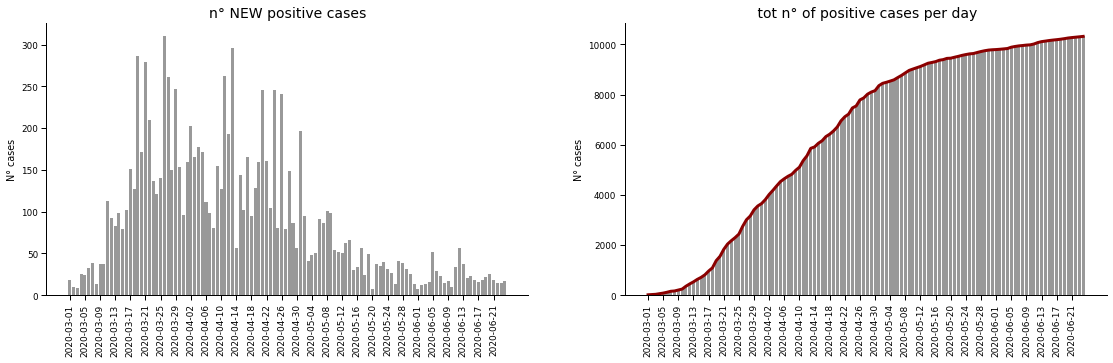

In [6]:
import seaborn as sns
#Real Data
sns.set_context('paper')
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(19,5))

axs[0].set_title('n° NEW positive cases', fontsize=14)
axs[0].bar(data.data , height =data.n_cases, color = 'k',alpha = 0.4)


axs[1].set_title(' tot n° of positive cases per day', fontsize=14)
axs[1].bar(data.data , height =data.cum_cases, color = 'k',alpha = 0.4)
axs[1].plot(data.data , data.cum_cases, color = 'darkred',alpha = 1, lw= 3)

for i in range(2):
    axs[i].set_ylabel('N° cases')
    axs[i].set_xticklabels(data.data.dt.date[::4], fontsize=9, rotation='vertical')
    axs[i].set_xticks(data.data.dt.date[::4] )
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)

In [ ]:
#Calibration, we picked the value of beta and exposure_distance minimizing the RMSE 
#Very slow, we run it for 20 h
MSEs = []
I_hats = []
gamma = 1 / 11.1
N = 13520
date_contagious = 2.9
percentage_imm = 0
percentage_asympt = 0.69
init_exposed = 0.00041568
bs = array([0.5,0.1,0.15,0.2,0.3,0.4])
exposure_distance = [100, 200, 300]
d = []
for b in bs:
    for exposure in exposure_distance:
        sss = []
        print(b, exposure)
        d.append([b,exposure])
        for i in range(10):
            beta = b
            # Run the model over time 
            model = InfectedModel(N, beta,
                                  gamma,
                                  date_contagious,
                                  percentage_imm,
                                  percentage_asympt,
                                  init_exposed,
                                  exposure)    
            while model.schedule.steps < 115: #115
                model.step()
            print('Simulation is over!')    
            RES = model.datacollector.get_model_vars_dataframe()
            I_hat = RES.Infected_Aux
            sss.append(I_hat)
        I_hat_averaged = np.mean(sss, axis = 0)
        MSE = np.sqrt(sum((I_hat_averaged-data.cum_cases1)**2)/len(data.cum_cases1))
        MSEs.append(MSE)
        I_hats.append(I_hat_averaged)

cal = pd.DataFrame({'b': d, 'MSE': MSEs, 'I_hat': I_hats})
#cal.to_csv('cal.csv')
cal = cal.sort_values('MSE').reset_index(drop=True)
print('BEST MODEL: beta: {}, exposure distance: {}, MSE:{}'.format(cal[0]['b'][0],cal[0]['b'][1], cal[0]['MSE']))

BEST MODEL: beta: 0.15, exposure distance: 100, MSE:14.750295


In [ ]:
#Running the experiments #Very slow code we run the simulation for 76 h
from mesa.batchrunner import BatchRunner

fixed_params = {'N':13520,
'gamma' :1 / 11.1,
'date_contagious':2.9,
'percentage_asympt':0.69,
'init_exposed':0.00041568,
'beta': 0.1, 
'exposure_distance': 100}

variable_params = {'percentage_imm':np.arange(0.2, 1.2, 0.2),,
                   'days_after_swab':[0,1,2,3,6]}

batch_run = BatchRunner(
    InfectedModel,  
    variable_parameters= variable_params, 
    fixed_parameters = fixed_params, 
    iterations = 30, 
    max_steps = 120, 
    model_reporters={"Data Collector": lambda m: m.datacollector.get_model_vars_dataframe()}) 

# Run the experiments
batch_run.run_all()  


In [ ]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

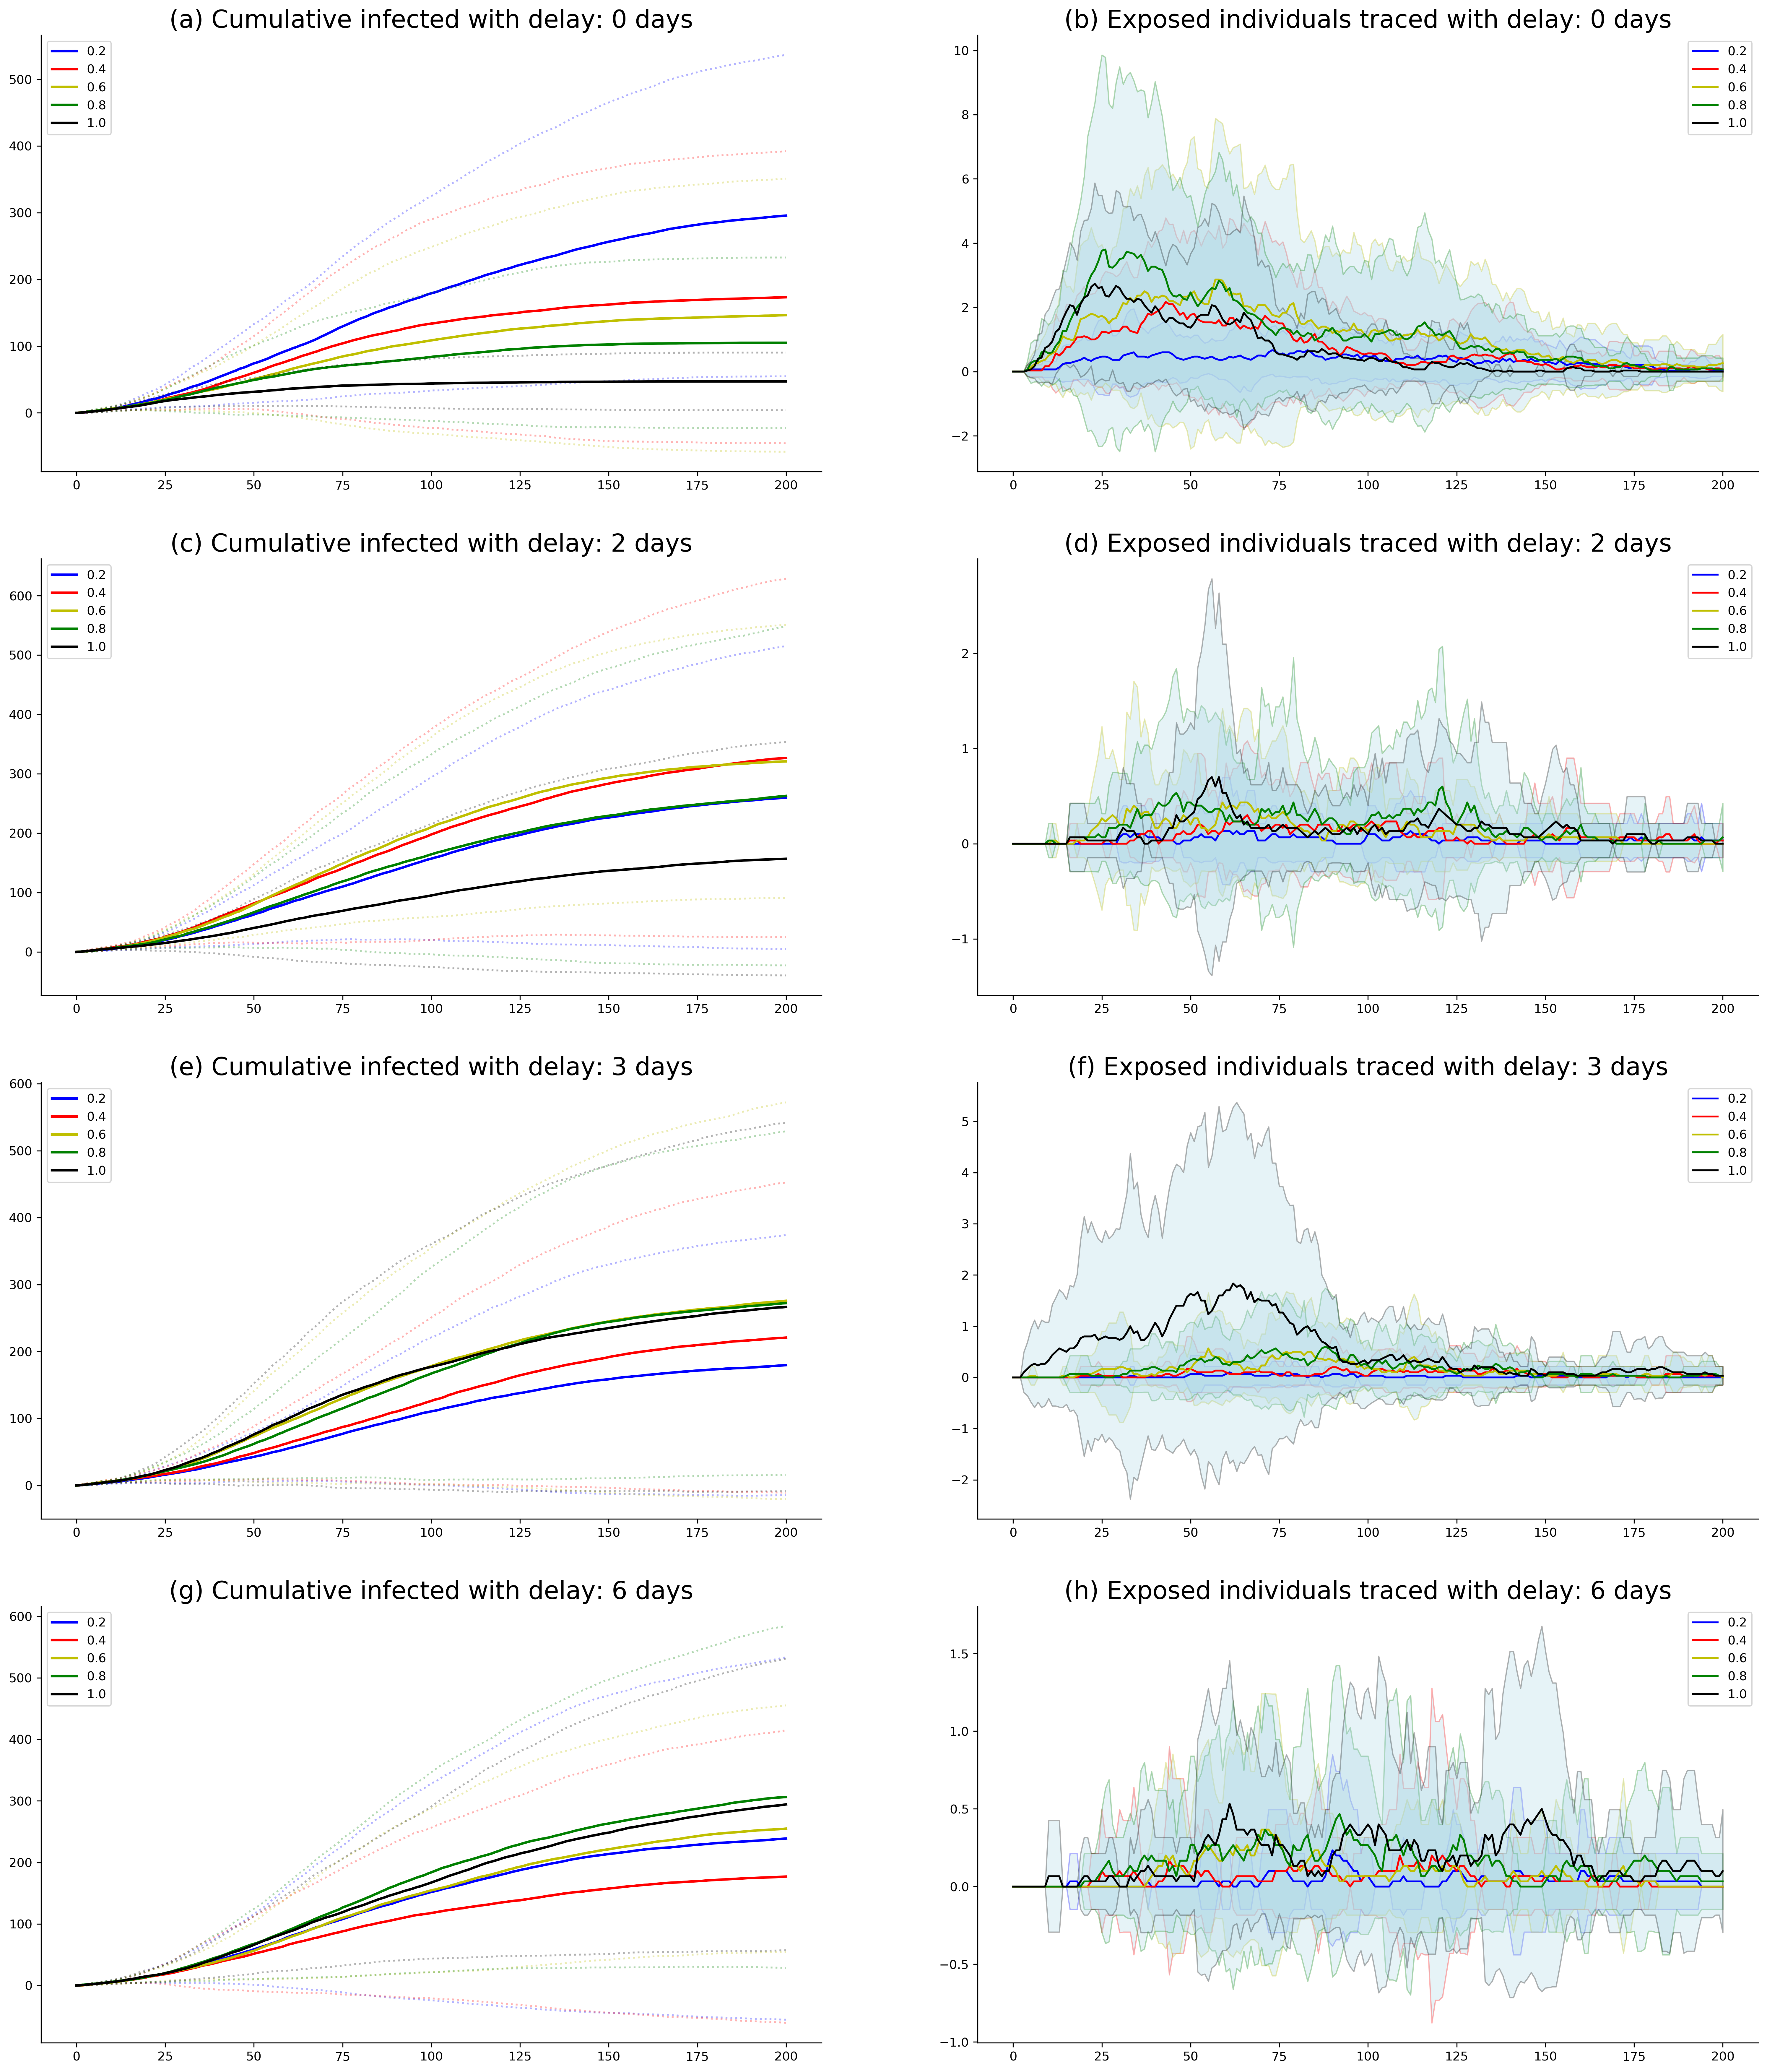

In [ ]:
'''
Plot for the graph.
The plot iterate for each delay and add two axis. On the left the cumulative Infected at time t. On the right se number of Exposed 
that have the app and they go in quarantine after they received the message.
'''

fig, axs = plt.subplots(4,2, facecolor='w', figsize=(25,30), dpi=300)
axs = axs.reshape(8)
axs = axs.flatten()

colors = ['b', 'r', 'y', 'g', 'black']
chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
counter = 0 #to iterate through axs 

for delay in [0,2,3,6]:
    notebooks_to_merge = [file for file in os.listdir('SENSITIVITY') if ('_' + str(delay)) in file]
    h = 0 #used to go trough the file. We did 30 iterations for each delay so 30 at the time
    label = 0.2 #used in the as label for te plot to keep track of downloads
    
    for g in range(0,5):
        EsTQ = []
        IAs_Total = []
        
        for i in notebooks_to_merge[0+h:30+h]:
                RES = pd.read_csv("SENSITIVITY\\" + str(i)) #go trough the file one at the time
                ETQ = RES['Exposed Q Traced']
                IA_Total = RES.Infected_Aux
                EsTQ.append(ETQ)
                IAs_Total.append(IA_Total)
        
        # Compute mean and std for each delay and for each percentage of download
        meanETQ = np.mean(EsTQ, axis=0)
        meanIA_Total =  np.mean(IAs_Total, axis=0)
        sdETQ = np.std(EsTQ, axis=0, dtype=np.float64)
        sdIA_Total = np.std(IAs_Total, axis=0, dtype=np.float64)
        t = np.arange(0, len(meanIA_Total), 1)

        # Plots 
        axs[counter].set_title('('+chars[counter]+') ' + 'Cumulative infected with delay: ' + str(delay) + ' days', fontsize = 20) 
        axs[counter].plot(t, meanIA_Total, lw=2, c = colors[g], label = round(label,2))   
        axs[counter].plot(t, meanIA_Total+sdIA_Total, meanIA_Total-sdIA_Total, c=colors[g], alpha=0.3, linestyle = ':') 
        
        axs[counter+1].set_title('('+chars[counter+1]+') ' + 'Exposed individuals traced with delay: '+ str(delay) + ' days', fontsize = 20)
        axs[counter+1].plot(t, meanETQ, c = colors[g], label = round(label,2))
        axs[counter+1].fill_between(t, meanETQ+sdETQ, meanETQ-sdETQ, facecolor = 'lightblue',edgecolor=colors[g], alpha=0.3)

        label += 0.2
        h += 30
        
    counter +=2
        
for i in range(8):
        axs[i].legend()
        for spine in ('top', 'right'): 
            axs[i].spines[spine].set_visible(False)

# fig.savefig('PLOT')